In [1]:
gpu_info = !nvidia-smi
gpu_info = gpu_info[:10]
gpu_info = '\n'.join(gpu_info)
print(gpu_info)

Wed Oct  7 23:47:29 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import sys
import torch
import os
import numpy as np
import torch.nn as nn
import torch.optim as optim

from tqdm.notebook import tqdm_notebook as tq

from torch.autograd import Variable
from torchvision.transforms import transforms
from torchvision.utils import save_image, make_grid
from torch.optim.lr_scheduler import StepLR
from torchsummary import summary

In [4]:
base_path = "/content/drive/My Drive/UC Davis Synthetic Data/Prashanth's/Autoencoder/Autoencoder/"
sys.path.append(base_path)
# torch.manual_seed(123)

In [5]:
from src.data_utils import LoadDataset, SavePath
from src.config import TrainConfig

In [6]:
args = TrainConfig( base_path,              # project directory path
                    n_epochs = 200,         # number of epochs to train (default: 100)
                    batch_size = 128,       # input batch size for training (default: 128)
                    lr = 0.0002,            # learning rate (default: 0.0001)
                    dim_h = 128,            # hidden dimension (default: 128)')
                    n_z = 8,                # hidden dimension of z (default: 8)
                    LAMBDA = 10,            # regularization coef term (default: 10)
                    sigma = 1,              # variance of hidden dimension (default: 1)
                    n_channel = 1,          # input channels (default: 1)
                    img_size = 28 )         # image size

In [7]:
def unfreeze_params(module: nn.Module):
    for p in module.parameters():
        p.requires_grad = True

def freeze_params(module: nn.Module):
    for p in module.parameters():
        p.requires_grad = False

In [44]:
def save_models(model_path, epoch_no):
    print("Saving models")
    torch.save(conv_encoder.state_dict(), model_path + "/conv_encoder_" + "%d.pth" % epoch_no)
    torch.save(conv_decoder.state_dict(), model_path + "/conv_decoder_" + "%d.pth" % epoch_no)
    torch.save(linear_encoder.state_dict(), model_path + "/linear_encoder_" + "%d.pth" % epoch_no)
    torch.save(linear_decoder.state_dict(), model_path + "/linear_decoder_" + "%d.pth" % epoch_no)
    torch.save(discriminator.state_dict(), model_path + "/discriminator_" + "%d.pth" % epoch_no)

def save_lists(list_path, epoch_no, reconstr_loss):
    print("Saving list")
    if reconstr_loss:
        np.savetxt(list_path + '/reconstr_loss_' + '%d.txt'% epoch_no, reconstr_loss)

In [10]:
# sp = SavePath(args, checkpoint_path="/content/drive/My Drive/UC Davis Synthetic Data/Prashanth's/Autoencoder/Autoencoder/outs/Tue-Sep-29-22-37-45-2020/")
sp = SavePath(args)

/content/drive/My Drive/UC Davis Synthetic Data/Prashanth's/Autoencoder/Autoencoder/outs/Wed-Oct--7-23-48-12-2020/


In [11]:
cdl = LoadDataset(args, data='mnist')
train_loader = cdl.get_data_loader(train=True)
test_loader = cdl.get_data_loader(train=False)

In [ ]:
# for step, (images, _) in enumerate(train_loader):
#     print(_[0])
#     images = images.cuda()
#     shape = images.size()
#     images = images.reshape([shape[0], shape[1], shape[2]*shape[3], 1])
#     print(images.shape)
#     complex_images = torch.cat((images, torch.zeros_like(images)), 3)
#     images_fft = complex_images.fft(signal_ndim=1, normalized=False)
#     # torch.fft()
#     images_ifft = images_fft.ifft(signal_ndim=1, normalized=False)
#     images_ifft = images_ifft.sum(3)
#     pixel = 150
#     # print(images_ifft.shape)
#     print(images[0][0][pixel], images_fft[0][0][pixel], images_ifft[0][0][pixel])
#     break

In [12]:
class LinearEncoder(nn.Module):

    def __init__(self, args):
        super(LinearEncoder, self).__init__()
        
        self.n_z = args.n_z
        self.dim_h = args.dim_h
        self.dim_input = args.img_size ** 2

        self.main = nn.Sequential(
            nn.Linear(self.dim_input, self.dim_h * 16),
            nn.ReLU(True),
            nn.Linear(self.dim_h * 16, self.dim_h * 8),
            nn.ReLU(True),
            nn.Linear(self.dim_h * 8, self.dim_h * 8),
            nn.ReLU(True),
            nn.Linear(self.dim_h * 8, self.dim_h * 4),
            nn.ReLU(True),
            nn.Linear(self.dim_h * 4, self.dim_h * 2),
            nn.ReLU(True),
            nn.Linear(self.dim_h * 2, self.dim_h),
            nn.ReLU(True),
            nn.Linear(self.dim_h, self.n_z)
        )
    
    def forward(self, x):
        x = self.main(x)
        return x

In [13]:
class LinearDecoder(nn.Module):

    def __init__(self, args):
        super(LinearDecoder, self).__init__()

        self.n_z = args.n_z
        self.dim_h = args.dim_h
        self.dim_output = args.img_size ** 2

        self.main = nn.Sequential(
            nn.Linear(self.n_z, self.dim_h),
            nn.ReLU(True),
            nn.Linear(self.dim_h, self.dim_h * 2),
            nn.ReLU(True),
            nn.Linear(self.dim_h * 2, self.dim_h * 4),
            nn.ReLU(True),
            nn.Linear(self.dim_h * 4, self.dim_h * 8),
            nn.ReLU(True),
            nn.Linear(self.dim_h * 8, self.dim_h * 8),
            nn.ReLU(True),
            nn.Linear(self.dim_h * 8, self.dim_h * 16),
            nn.ReLU(True),
            nn.Linear(self.dim_h * 16, self.dim_output),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = self.main(x)
        return x

In [14]:
class Discriminator(nn.Module):
    def __init__(self, args):
        super(Discriminator, self).__init__()

        self.dim_h = args.dim_h
        self.n_z = args.n_z

        self.main = nn.Sequential(
            nn.Linear(self.n_z, self.dim_h * 4),
            nn.ReLU(True),
            nn.Linear(self.dim_h * 4, self.dim_h * 4),
            nn.ReLU(True),
            nn.Linear(self.dim_h * 4, self.dim_h * 4),
            nn.ReLU(True),
            nn.Linear(self.dim_h * 4, self.dim_h * 4),
            nn.ReLU(True),
            nn.Linear(self.dim_h * 4, self.dim_h * 4),
            nn.ReLU(True),
            nn.Linear(self.dim_h * 4, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.main(x)
        return x

In [15]:
from src.model import Encoder as ConvEncoder
from src.model import Decoder as ConvDecoder

In [16]:
conv_encoder, conv_decoder = ConvEncoder(args).cuda(), ConvDecoder(args).cuda()
linear_encoder, linear_decoder = LinearEncoder(args).cuda(), LinearDecoder(args).cuda()
discriminator = Discriminator(args).cuda()

criterion = nn.MSELoss()

models = [conv_encoder, conv_decoder, linear_encoder, linear_decoder, discriminator]
for i in range(len(models)):
    models[i].train()

# Optimizers
optimizers = [optim.Adam(models[i].parameters(), lr = args.lr) for i in range(len(models)-1)]
optimizers.append(optim.Adam(discriminator.parameters(), lr = 0.5*args.lr))

In [ ]:
summary(discriminator, (1, 8))
summary(decoder, (1, 8))
summary(encoder, (1, 784))

In [17]:
checkpoint = 0

if checkpoint:
    _, list_path, model_path = sp.get_save_paths()

    encoder.load_state_dict(torch.load(
                    model_path + "/encoder_{}.pth".format(checkpoint)))
    decoder.load_state_dict(torch.load(
                    model_path + "/decoder_{}.pth".format(checkpoint)))
    discriminator.load_state_dict(torch.load(
            model_path + "/discriminator_{}.pth".format(checkpoint)))
    reconstr_loss_epoch = np.loadtxt(
        list_path + '/reconstr_loss_{}.txt'.format(checkpoint)).tolist()
else:
    reconstr_loss_epoch = []
reconstr_loss = []
disc_loss = []
d_real_val = []

In [18]:
image_path, list_path, model_path = sp.get_save_paths()

In [ ]:
for epoch in range(checkpoint, checkpoint+args.n_epochs):
    for step, (images, _) in tq(enumerate(train_loader)):

        images = images.cuda()
        images_flattened = images.reshape([images.size()[0], 1, args.img_size**2])
        
        for i in range(len(models)):
            models[i].zero_grad()

        # ======== Train Discriminator ======== #

        unfreeze_params(discriminator)
        for i in range(len(models)-1):
            freeze_params(models[i])

        z_dist = torch.randn(images.size()[0], args.n_z) * args.sigma
        z_dist = z_dist.cuda().detach()

        z_linear = linear_encoder(images_flattened).detach()
        z_conv = conv_encoder(images).detach()

        d_dist = discriminator(z_dist)
        d_linear = discriminator(z_linear)
        d_conv = discriminator(z_conv)
        
        d_loss = -(torch.log(d_dist.mean()) + torch.log((1 - d_linear).mean()) + torch.log((1 - d_conv).mean()))

        disc_loss.append([d_dist.mean().item(), d_linear.mean().item(), d_conv.mean().item()])

        d_loss.backward()

        optimizers[4].step()

        # ======== Train Generator ======== #
        
        freeze_params(discriminator)
        for i in range(len(models)-1):
            unfreeze_params(models[i])

        batch_size = images.size()[0]

        z_conv_real = conv_encoder(images)
        z_linear_real = linear_encoder(images_flattened)

        conv_recon = conv_decoder(z_conv_real)
        linear_recon = linear_decoder(z_linear_real)
        
        d_conv_real = discriminator(z_conv_real)
        d_linear_real = discriminator(z_linear_real)

        recon_loss = criterion(conv_recon, images) + criterion(linear_recon, images_flattened)
        # - args.LAMBDA * (torch.log(d_real)).mean()

        reg_loss = -(args.LAMBDA * (torch.log(d_conv_real).mean() + torch.log(d_linear_real).mean()))

        distance_loss = args.LAMBDA * criterion(z_conv_real, z_linear_real.squeeze())

        total_loss = recon_loss + reg_loss + distance_loss
        # recon_loss.backward()
        # reg_loss.backward()
        # distance_loss.backward()

        total_loss.backward()

        d_real_val.append([reg_loss.item(), distance_loss.item()])
        reconstr_loss.append(recon_loss.data.item())

        for i in range(len(optimizers)-1):
            optimizers[i].step()
            

    if (epoch + 1) % 1 == 0:
        temp = np.mean(disc_loss, axis=0)
        temp1 = np.mean(d_real_val, axis=0)
        print("Epoch: [%d/%d], Recon Loss: [%.4f], reg_loss: [%.4f], distance_loss: [%.4f], d_dist: [%.4f], d_linear: [%.4f], d_conv: [%.4f]" %
                (epoch + 1, args.n_epochs, 
                 np.mean(reconstr_loss), temp1[0], temp1[1], temp[0], temp[1], temp[2]))
        disc_loss.clear()
        d_real_val.clear()
    
    if (epoch + 1) % 1 == 0:

        # reconstr_loss_epoch.append(np.mean(reconstr_loss))
        # reconstr_loss.clear()

        batch_size = args.batch_size // 2
        test_iter = iter(test_loader)
        test_images, _ = next(test_iter)
        test_images = Variable(test_images)[:64]
        test_images_flattened = test_images[:64].reshape([batch_size, 1, args.img_size**2])

        z_conv = conv_encoder(test_images.cuda()).detach()
        z_linear = linear_encoder(test_images_flattened.cuda()).detach()

        z_dist = torch.randn_like(z_linear).cuda()

        conv_sample = make_grid(conv_decoder(z_dist).detach().cpu().view(batch_size, 1, 28, 28))
        linear_sample = make_grid(linear_decoder(z_dist).detach().cpu().view(batch_size, 1, 28, 28))

        sample = torch.cat((conv_sample, linear_sample), axis=1)
 
        image = torch.cat((test_images.view(batch_size, 1, 28, 28), 
                           conv_decoder(z_conv).cpu().view(batch_size, 1, 28, 28).data,
                           linear_decoder(z_linear).cpu().view(batch_size, 1, 28, 28).data,
                           conv_decoder(z_linear).cpu().view(batch_size, 1, 28, 28).data,
                           linear_decoder(z_conv).cpu().view(batch_size, 1, 28, 28).data
                           ), axis=3)
        
        save_image(image, image_path +
                                '/inputs_reconstr_{}.png'.format(epoch+1), pad_value=1)
        
        save_image(sample, image_path + 
                                '/sample_{}.png'.format(epoch+1), pad_value=1)

    if (epoch + 1) % 25 == 0:
        save_models(model_path, epoch+1)
        # save_lists(list_path, epoch+1, reconstr_loss_epoch)
    


Epoch: [1/200], Recon Loss: [0.1153], reg_loss: [25.9380], distance_loss: [3.4981], d_dist: [0.3320], d_linear: [0.4101], d_conv: [0.2254]



Epoch: [2/200], Recon Loss: [0.1150], reg_loss: [24.6111], distance_loss: [3.2491], d_dist: [0.3351], d_linear: [0.4159], d_conv: [0.2413]



Epoch: [3/200], Recon Loss: [0.1147], reg_loss: [25.5122], distance_loss: [2.9307], d_dist: [0.3487], d_linear: [0.3961], d_conv: [0.2544]



Epoch: [4/200], Recon Loss: [0.1146], reg_loss: [28.4103], distance_loss: [5.6001], d_dist: [0.3393], d_linear: [0.4273], d_conv: [0.2131]



Epoch: [5/200], Recon Loss: [0.1141], reg_loss: [22.7164], distance_loss: [2.1186], d_dist: [0.3426], d_linear: [0.3864], d_conv: [0.2889]



Epoch: [6/200], Recon Loss: [0.1137], reg_loss: [24.1077], distance_loss: [3.0489], d_dist: [0.3407], d_linear: [0.4152], d_conv: [0.2527]



Epoch: [7/200], Recon Loss: [0.1134], reg_loss: [23.1685], distance_loss: [2.5171], d_dist: [0.3357], d_linear: [0.3895], d_conv: [0.2778]



Epoch: [8/200], Recon Loss: [0.1130], reg_loss: [22.8055], distance_loss: [2.1772], d_dist: [0.3425], d_linear: [0.3907], d_conv: [0.2830]



Epoch: [9/200], Recon Loss: [0.1127], reg_loss: [25.6842], distance_loss: [3.7261], d_dist: [0.3439], d_linear: [0.4045], d_conv: [0.2466]



Epoch: [10/200], Recon Loss: [0.1125], reg_loss: [24.7306], distance_loss: [4.2598], d_dist: [0.3226], d_linear: [0.4126], d_conv: [0.2555]



Epoch: [11/200], Recon Loss: [0.1121], reg_loss: [24.2999], distance_loss: [2.9965], d_dist: [0.3389], d_linear: [0.4058], d_conv: [0.2556]



Epoch: [12/200], Recon Loss: [0.1117], reg_loss: [22.8742], distance_loss: [1.9212], d_dist: [0.3421], d_linear: [0.3807], d_conv: [0.2876]



Epoch: [13/200], Recon Loss: [0.1113], reg_loss: [23.4457], distance_loss: [2.5378], d_dist: [0.3332], d_linear: [0.3943], d_conv: [0.2702]



Epoch: [14/200], Recon Loss: [0.1109], reg_loss: [23.9571], distance_loss: [2.9159], d_dist: [0.3329], d_linear: [0.4112], d_conv: [0.2543]



Epoch: [15/200], Recon Loss: [0.1104], reg_loss: [22.8033], distance_loss: [1.7452], d_dist: [0.3367], d_linear: [0.3751], d_conv: [0.2901]



Epoch: [16/200], Recon Loss: [0.1099], reg_loss: [22.7038], distance_loss: [1.4617], d_dist: [0.3374], d_linear: [0.3648], d_conv: [0.3007]



Epoch: [17/200], Recon Loss: [0.1096], reg_loss: [24.6202], distance_loss: [3.7878], d_dist: [0.3362], d_linear: [0.4050], d_conv: [0.2558]



Epoch: [18/200], Recon Loss: [0.1091], reg_loss: [23.1729], distance_loss: [2.3663], d_dist: [0.3433], d_linear: [0.3938], d_conv: [0.2752]



Epoch: [19/200], Recon Loss: [0.1086], reg_loss: [24.5032], distance_loss: [2.7157], d_dist: [0.3380], d_linear: [0.3872], d_conv: [0.2609]



Epoch: [20/200], Recon Loss: [0.1082], reg_loss: [23.6118], distance_loss: [2.9127], d_dist: [0.3337], d_linear: [0.4034], d_conv: [0.2623]



Epoch: [21/200], Recon Loss: [0.1078], reg_loss: [24.0605], distance_loss: [3.0431], d_dist: [0.3396], d_linear: [0.4053], d_conv: [0.2550]



Epoch: [22/200], Recon Loss: [0.1074], reg_loss: [24.1872], distance_loss: [3.6761], d_dist: [0.3414], d_linear: [0.4159], d_conv: [0.2471]



Epoch: [23/200], Recon Loss: [0.1070], reg_loss: [24.8188], distance_loss: [3.2574], d_dist: [0.3352], d_linear: [0.4011], d_conv: [0.2508]



Epoch: [24/200], Recon Loss: [0.1066], reg_loss: [24.0278], distance_loss: [3.0526], d_dist: [0.3425], d_linear: [0.4080], d_conv: [0.2574]



Epoch: [25/200], Recon Loss: [0.1062], reg_loss: [23.2680], distance_loss: [2.6225], d_dist: [0.3554], d_linear: [0.4030], d_conv: [0.2773]
Saving models



Epoch: [26/200], Recon Loss: [0.1058], reg_loss: [23.8633], distance_loss: [2.8218], d_dist: [0.3476], d_linear: [0.3983], d_conv: [0.2659]



Epoch: [27/200], Recon Loss: [0.1053], reg_loss: [24.8748], distance_loss: [3.4714], d_dist: [0.3306], d_linear: [0.3946], d_conv: [0.2439]



Epoch: [28/200], Recon Loss: [0.1050], reg_loss: [25.0701], distance_loss: [3.6956], d_dist: [0.3380], d_linear: [0.4059], d_conv: [0.2474]



Epoch: [29/200], Recon Loss: [0.1047], reg_loss: [24.9660], distance_loss: [4.3777], d_dist: [0.3390], d_linear: [0.4192], d_conv: [0.2535]



Epoch: [30/200], Recon Loss: [0.1042], reg_loss: [23.3302], distance_loss: [2.4924], d_dist: [0.3435], d_linear: [0.3934], d_conv: [0.2718]



Epoch: [31/200], Recon Loss: [0.1037], reg_loss: [23.2941], distance_loss: [2.2708], d_dist: [0.3353], d_linear: [0.3881], d_conv: [0.2768]



Epoch: [32/200], Recon Loss: [0.1033], reg_loss: [22.9121], distance_loss: [2.5339], d_dist: [0.3537], d_linear: [0.4016], d_conv: [0.2780]



Epoch: [33/200], Recon Loss: [0.1029], reg_loss: [23.4484], distance_loss: [2.6473], d_dist: [0.3378], d_linear: [0.4023], d_conv: [0.2692]



Epoch: [34/200], Recon Loss: [0.1025], reg_loss: [23.1279], distance_loss: [2.5161], d_dist: [0.3380], d_linear: [0.3935], d_conv: [0.2736]



Epoch: [35/200], Recon Loss: [0.1022], reg_loss: [23.2202], distance_loss: [2.1002], d_dist: [0.3344], d_linear: [0.3814], d_conv: [0.2792]



Epoch: [36/200], Recon Loss: [0.1017], reg_loss: [23.0848], distance_loss: [1.8595], d_dist: [0.3318], d_linear: [0.3723], d_conv: [0.2837]



Epoch: [37/200], Recon Loss: [0.1012], reg_loss: [22.7349], distance_loss: [1.6155], d_dist: [0.3323], d_linear: [0.3719], d_conv: [0.2937]



Epoch: [38/200], Recon Loss: [0.1006], reg_loss: [22.5166], distance_loss: [1.2129], d_dist: [0.3349], d_linear: [0.3574], d_conv: [0.3069]



Epoch: [39/200], Recon Loss: [0.1001], reg_loss: [22.7889], distance_loss: [1.2932], d_dist: [0.3284], d_linear: [0.3574], d_conv: [0.2998]



Epoch: [40/200], Recon Loss: [0.0995], reg_loss: [22.7405], distance_loss: [1.2316], d_dist: [0.3309], d_linear: [0.3568], d_conv: [0.3015]



Epoch: [41/200], Recon Loss: [0.0989], reg_loss: [22.3210], distance_loss: [1.1035], d_dist: [0.3350], d_linear: [0.3605], d_conv: [0.3103]



Epoch: [42/200], Recon Loss: [0.0984], reg_loss: [22.4951], distance_loss: [0.9829], d_dist: [0.3332], d_linear: [0.3518], d_conv: [0.3109]



Epoch: [43/200], Recon Loss: [0.0978], reg_loss: [22.2171], distance_loss: [1.0408], d_dist: [0.3358], d_linear: [0.3607], d_conv: [0.3133]



Epoch: [44/200], Recon Loss: [0.0972], reg_loss: [22.5517], distance_loss: [0.5863], d_dist: [0.3282], d_linear: [0.3367], d_conv: [0.3176]



Epoch: [45/200], Recon Loss: [0.0966], reg_loss: [22.3406], distance_loss: [0.8643], d_dist: [0.3341], d_linear: [0.3524], d_conv: [0.3142]



Epoch: [46/200], Recon Loss: [0.0961], reg_loss: [22.5922], distance_loss: [0.7557], d_dist: [0.3283], d_linear: [0.3422], d_conv: [0.3138]



Epoch: [47/200], Recon Loss: [0.0955], reg_loss: [22.3744], distance_loss: [0.7514], d_dist: [0.3308], d_linear: [0.3468], d_conv: [0.3163]



Epoch: [48/200], Recon Loss: [0.0950], reg_loss: [22.2778], distance_loss: [0.6594], d_dist: [0.3327], d_linear: [0.3456], d_conv: [0.3194]



Epoch: [49/200], Recon Loss: [0.0944], reg_loss: [22.2059], distance_loss: [0.7054], d_dist: [0.3342], d_linear: [0.3492], d_conv: [0.3196]



Epoch: [50/200], Recon Loss: [0.0939], reg_loss: [22.3291], distance_loss: [0.7683], d_dist: [0.3341], d_linear: [0.3499], d_conv: [0.3166]
Saving models



Epoch: [51/200], Recon Loss: [0.0934], reg_loss: [22.5265], distance_loss: [0.8167], d_dist: [0.3293], d_linear: [0.3469], d_conv: [0.3132]



Epoch: [52/200], Recon Loss: [0.0929], reg_loss: [22.0920], distance_loss: [0.7519], d_dist: [0.3357], d_linear: [0.3527], d_conv: [0.3207]



Epoch: [53/200], Recon Loss: [0.0924], reg_loss: [22.5746], distance_loss: [0.8128], d_dist: [0.3277], d_linear: [0.3460], d_conv: [0.3122]



Epoch: [54/200], Recon Loss: [0.0919], reg_loss: [22.2774], distance_loss: [0.6969], d_dist: [0.3332], d_linear: [0.3473], d_conv: [0.3183]



Epoch: [55/200], Recon Loss: [0.0915], reg_loss: [22.2536], distance_loss: [0.7315], d_dist: [0.3333], d_linear: [0.3486], d_conv: [0.3182]



Epoch: [56/200], Recon Loss: [0.0910], reg_loss: [22.3173], distance_loss: [0.7380], d_dist: [0.3302], d_linear: [0.3487], d_conv: [0.3167]



Epoch: [57/200], Recon Loss: [0.0906], reg_loss: [22.1753], distance_loss: [0.7400], d_dist: [0.3334], d_linear: [0.3513], d_conv: [0.3182]



Epoch: [58/200], Recon Loss: [0.0901], reg_loss: [22.2081], distance_loss: [0.5422], d_dist: [0.3322], d_linear: [0.3423], d_conv: [0.3234]



Epoch: [59/200], Recon Loss: [0.0896], reg_loss: [22.2240], distance_loss: [0.4781], d_dist: [0.3314], d_linear: [0.3401], d_conv: [0.3239]



Epoch: [60/200], Recon Loss: [0.0892], reg_loss: [22.1698], distance_loss: [0.5441], d_dist: [0.3337], d_linear: [0.3438], d_conv: [0.3236]



Epoch: [61/200], Recon Loss: [0.0888], reg_loss: [22.2226], distance_loss: [0.6412], d_dist: [0.3327], d_linear: [0.3460], d_conv: [0.3207]



Epoch: [62/200], Recon Loss: [0.0884], reg_loss: [22.2363], distance_loss: [0.5922], d_dist: [0.3322], d_linear: [0.3438], d_conv: [0.3214]



Epoch: [63/200], Recon Loss: [0.0880], reg_loss: [22.0315], distance_loss: [0.4785], d_dist: [0.3351], d_linear: [0.3431], d_conv: [0.3272]



Epoch: [64/200], Recon Loss: [0.0875], reg_loss: [22.1527], distance_loss: [0.5151], d_dist: [0.3332], d_linear: [0.3427], d_conv: [0.3242]



Epoch: [65/200], Recon Loss: [0.0871], reg_loss: [22.1705], distance_loss: [0.4925], d_dist: [0.3333], d_linear: [0.3418], d_conv: [0.3238]



Epoch: [66/200], Recon Loss: [0.0867], reg_loss: [22.2058], distance_loss: [0.5703], d_dist: [0.3324], d_linear: [0.3442], d_conv: [0.3220]



Epoch: [67/200], Recon Loss: [0.0864], reg_loss: [22.1498], distance_loss: [0.5469], d_dist: [0.3325], d_linear: [0.3438], d_conv: [0.3235]



Epoch: [68/200], Recon Loss: [0.0860], reg_loss: [22.3458], distance_loss: [0.5348], d_dist: [0.3297], d_linear: [0.3409], d_conv: [0.3201]



Epoch: [69/200], Recon Loss: [0.0856], reg_loss: [22.2020], distance_loss: [0.4570], d_dist: [0.3312], d_linear: [0.3398], d_conv: [0.3240]



Epoch: [70/200], Recon Loss: [0.0852], reg_loss: [22.1107], distance_loss: [0.5561], d_dist: [0.3343], d_linear: [0.3454], d_conv: [0.3234]



Epoch: [71/200], Recon Loss: [0.0848], reg_loss: [22.2128], distance_loss: [0.4707], d_dist: [0.3310], d_linear: [0.3403], d_conv: [0.3234]



Epoch: [72/200], Recon Loss: [0.0845], reg_loss: [22.2477], distance_loss: [0.5824], d_dist: [0.3312], d_linear: [0.3431], d_conv: [0.3219]



Epoch: [73/200], Recon Loss: [0.0841], reg_loss: [22.0682], distance_loss: [0.4761], d_dist: [0.3335], d_linear: [0.3435], d_conv: [0.3256]



Epoch: [74/200], Recon Loss: [0.0838], reg_loss: [22.0674], distance_loss: [0.4755], d_dist: [0.3340], d_linear: [0.3435], d_conv: [0.3254]



Epoch: [75/200], Recon Loss: [0.0835], reg_loss: [22.0755], distance_loss: [0.5211], d_dist: [0.3334], d_linear: [0.3446], d_conv: [0.3249]
Saving models



Epoch: [76/200], Recon Loss: [0.0831], reg_loss: [22.0847], distance_loss: [0.4682], d_dist: [0.3330], d_linear: [0.3422], d_conv: [0.3257]



Epoch: [77/200], Recon Loss: [0.0828], reg_loss: [22.2555], distance_loss: [0.4440], d_dist: [0.3305], d_linear: [0.3385], d_conv: [0.3238]



Epoch: [78/200], Recon Loss: [0.0825], reg_loss: [22.1990], distance_loss: [0.4513], d_dist: [0.3317], d_linear: [0.3403], d_conv: [0.3242]



Epoch: [79/200], Recon Loss: [0.0821], reg_loss: [22.2174], distance_loss: [0.4365], d_dist: [0.3317], d_linear: [0.3392], d_conv: [0.3244]



Epoch: [80/200], Recon Loss: [0.0818], reg_loss: [22.2291], distance_loss: [0.4392], d_dist: [0.3306], d_linear: [0.3389], d_conv: [0.3243]



Epoch: [81/200], Recon Loss: [0.0815], reg_loss: [22.0936], distance_loss: [0.4301], d_dist: [0.3333], d_linear: [0.3407], d_conv: [0.3267]



Epoch: [82/200], Recon Loss: [0.0812], reg_loss: [22.1425], distance_loss: [0.3981], d_dist: [0.3321], d_linear: [0.3391], d_conv: [0.3261]



Epoch: [83/200], Recon Loss: [0.0809], reg_loss: [22.1104], distance_loss: [0.3884], d_dist: [0.3325], d_linear: [0.3392], d_conv: [0.3273]



Epoch: [84/200], Recon Loss: [0.0806], reg_loss: [22.1818], distance_loss: [0.4515], d_dist: [0.3315], d_linear: [0.3402], d_conv: [0.3250]



Epoch: [85/200], Recon Loss: [0.0803], reg_loss: [22.1593], distance_loss: [0.4469], d_dist: [0.3324], d_linear: [0.3416], d_conv: [0.3244]



Epoch: [86/200], Recon Loss: [0.0800], reg_loss: [22.1519], distance_loss: [0.4194], d_dist: [0.3316], d_linear: [0.3395], d_conv: [0.3254]



Epoch: [87/200], Recon Loss: [0.0797], reg_loss: [22.0490], distance_loss: [0.4456], d_dist: [0.3337], d_linear: [0.3428], d_conv: [0.3263]



Epoch: [88/200], Recon Loss: [0.0794], reg_loss: [22.1607], distance_loss: [0.4521], d_dist: [0.3318], d_linear: [0.3409], d_conv: [0.3245]



Epoch: [89/200], Recon Loss: [0.0792], reg_loss: [21.9990], distance_loss: [0.3700], d_dist: [0.3347], d_linear: [0.3401], d_conv: [0.3290]



Epoch: [90/200], Recon Loss: [0.0789], reg_loss: [22.1592], distance_loss: [0.5046], d_dist: [0.3314], d_linear: [0.3416], d_conv: [0.3247]



Epoch: [91/200], Recon Loss: [0.0786], reg_loss: [22.2051], distance_loss: [0.4497], d_dist: [0.3311], d_linear: [0.3405], d_conv: [0.3240]



Epoch: [92/200], Recon Loss: [0.0784], reg_loss: [22.0813], distance_loss: [0.4671], d_dist: [0.3335], d_linear: [0.3429], d_conv: [0.3258]



Epoch: [93/200], Recon Loss: [0.0781], reg_loss: [22.1923], distance_loss: [0.4418], d_dist: [0.3313], d_linear: [0.3396], d_conv: [0.3243]



Epoch: [94/200], Recon Loss: [0.0779], reg_loss: [22.1454], distance_loss: [0.3920], d_dist: [0.3318], d_linear: [0.3390], d_conv: [0.3258]



Epoch: [95/200], Recon Loss: [0.0776], reg_loss: [22.0097], distance_loss: [0.3648], d_dist: [0.3339], d_linear: [0.3398], d_conv: [0.3291]



Epoch: [96/200], Recon Loss: [0.0773], reg_loss: [22.1242], distance_loss: [0.3698], d_dist: [0.3323], d_linear: [0.3381], d_conv: [0.3269]



Epoch: [97/200], Recon Loss: [0.0771], reg_loss: [22.1294], distance_loss: [0.4180], d_dist: [0.3326], d_linear: [0.3399], d_conv: [0.3261]



Epoch: [98/200], Recon Loss: [0.0769], reg_loss: [22.0559], distance_loss: [0.3762], d_dist: [0.3334], d_linear: [0.3396], d_conv: [0.3279]



Epoch: [99/200], Recon Loss: [0.0766], reg_loss: [22.1303], distance_loss: [0.4661], d_dist: [0.3327], d_linear: [0.3425], d_conv: [0.3252]



Epoch: [100/200], Recon Loss: [0.0764], reg_loss: [21.9970], distance_loss: [0.3466], d_dist: [0.3340], d_linear: [0.3394], d_conv: [0.3295]
Saving models



Epoch: [101/200], Recon Loss: [0.0761], reg_loss: [22.0881], distance_loss: [0.3602], d_dist: [0.3329], d_linear: [0.3391], d_conv: [0.3274]



Epoch: [102/200], Recon Loss: [0.0759], reg_loss: [22.1054], distance_loss: [0.3873], d_dist: [0.3324], d_linear: [0.3392], d_conv: [0.3267]



Epoch: [103/200], Recon Loss: [0.0757], reg_loss: [22.1167], distance_loss: [0.4201], d_dist: [0.3324], d_linear: [0.3405], d_conv: [0.3258]



Epoch: [104/200], Recon Loss: [0.0754], reg_loss: [22.0796], distance_loss: [0.4624], d_dist: [0.3329], d_linear: [0.3426], d_conv: [0.3258]



Epoch: [105/200], Recon Loss: [0.0752], reg_loss: [22.0158], distance_loss: [0.3163], d_dist: [0.3339], d_linear: [0.3371], d_conv: [0.3304]



Epoch: [106/200], Recon Loss: [0.0750], reg_loss: [22.2357], distance_loss: [0.3790], d_dist: [0.3306], d_linear: [0.3368], d_conv: [0.3249]



Epoch: [107/200], Recon Loss: [0.0748], reg_loss: [22.1053], distance_loss: [0.3568], d_dist: [0.3324], d_linear: [0.3383], d_conv: [0.3273]



Epoch: [108/200], Recon Loss: [0.0746], reg_loss: [22.1607], distance_loss: [0.4216], d_dist: [0.3326], d_linear: [0.3403], d_conv: [0.3251]



Epoch: [109/200], Recon Loss: [0.0744], reg_loss: [22.0887], distance_loss: [0.3622], d_dist: [0.3322], d_linear: [0.3383], d_conv: [0.3279]



Epoch: [110/200], Recon Loss: [0.0741], reg_loss: [22.1070], distance_loss: [0.3269], d_dist: [0.3321], d_linear: [0.3371], d_conv: [0.3279]



Epoch: [111/200], Recon Loss: [0.0739], reg_loss: [22.0591], distance_loss: [0.3626], d_dist: [0.3335], d_linear: [0.3398], d_conv: [0.3279]



Epoch: [112/200], Recon Loss: [0.0737], reg_loss: [21.9889], distance_loss: [0.3304], d_dist: [0.3342], d_linear: [0.3395], d_conv: [0.3298]



Epoch: [113/200], Recon Loss: [0.0735], reg_loss: [22.0860], distance_loss: [0.3676], d_dist: [0.3325], d_linear: [0.3389], d_conv: [0.3276]



Epoch: [114/200], Recon Loss: [0.0733], reg_loss: [22.1442], distance_loss: [0.4408], d_dist: [0.3323], d_linear: [0.3411], d_conv: [0.3251]



Epoch: [115/200], Recon Loss: [0.0731], reg_loss: [22.1178], distance_loss: [0.3760], d_dist: [0.3319], d_linear: [0.3386], d_conv: [0.3269]



Epoch: [116/200], Recon Loss: [0.0729], reg_loss: [21.9951], distance_loss: [0.3662], d_dist: [0.3339], d_linear: [0.3406], d_conv: [0.3291]



Epoch: [117/200], Recon Loss: [0.0727], reg_loss: [22.1305], distance_loss: [0.3315], d_dist: [0.3318], d_linear: [0.3370], d_conv: [0.3273]



Epoch: [118/200], Recon Loss: [0.0725], reg_loss: [22.0271], distance_loss: [0.3139], d_dist: [0.3334], d_linear: [0.3380], d_conv: [0.3297]



Epoch: [119/200], Recon Loss: [0.0723], reg_loss: [22.1422], distance_loss: [0.3409], d_dist: [0.3316], d_linear: [0.3371], d_conv: [0.3274]



Epoch: [120/200], Recon Loss: [0.0721], reg_loss: [22.1443], distance_loss: [0.4004], d_dist: [0.3319], d_linear: [0.3387], d_conv: [0.3266]



Epoch: [121/200], Recon Loss: [0.0720], reg_loss: [22.0443], distance_loss: [0.4271], d_dist: [0.3337], d_linear: [0.3423], d_conv: [0.3269]



Epoch: [122/200], Recon Loss: [0.0718], reg_loss: [22.0522], distance_loss: [0.2917], d_dist: [0.3333], d_linear: [0.3369], d_conv: [0.3294]



Epoch: [123/200], Recon Loss: [0.0716], reg_loss: [22.0696], distance_loss: [0.3355], d_dist: [0.3328], d_linear: [0.3381], d_conv: [0.3285]



Epoch: [124/200], Recon Loss: [0.0714], reg_loss: [22.0056], distance_loss: [0.3706], d_dist: [0.3338], d_linear: [0.3406], d_conv: [0.3286]



Epoch: [125/200], Recon Loss: [0.0713], reg_loss: [22.0897], distance_loss: [0.3069], d_dist: [0.3324], d_linear: [0.3365], d_conv: [0.3287]
Saving models



Epoch: [126/200], Recon Loss: [0.0711], reg_loss: [22.1192], distance_loss: [0.3718], d_dist: [0.3322], d_linear: [0.3393], d_conv: [0.3267]



Epoch: [127/200], Recon Loss: [0.0709], reg_loss: [22.1482], distance_loss: [0.3644], d_dist: [0.3317], d_linear: [0.3378], d_conv: [0.3266]



Epoch: [128/200], Recon Loss: [0.0708], reg_loss: [22.0221], distance_loss: [0.3706], d_dist: [0.3334], d_linear: [0.3405], d_conv: [0.3283]



Epoch: [129/200], Recon Loss: [0.0706], reg_loss: [22.0726], distance_loss: [0.3687], d_dist: [0.3329], d_linear: [0.3391], d_conv: [0.3279]



Epoch: [130/200], Recon Loss: [0.0704], reg_loss: [22.0439], distance_loss: [0.3809], d_dist: [0.3338], d_linear: [0.3406], d_conv: [0.3278]



Epoch: [131/200], Recon Loss: [0.0703], reg_loss: [22.0582], distance_loss: [0.3730], d_dist: [0.3328], d_linear: [0.3402], d_conv: [0.3277]



Epoch: [132/200], Recon Loss: [0.0701], reg_loss: [22.0456], distance_loss: [0.2959], d_dist: [0.3329], d_linear: [0.3369], d_conv: [0.3295]



Epoch: [133/200], Recon Loss: [0.0699], reg_loss: [22.0881], distance_loss: [0.3401], d_dist: [0.3321], d_linear: [0.3382], d_conv: [0.3278]



Epoch: [134/200], Recon Loss: [0.0698], reg_loss: [22.1255], distance_loss: [0.3027], d_dist: [0.3317], d_linear: [0.3363], d_conv: [0.3280]



Epoch: [135/200], Recon Loss: [0.0696], reg_loss: [22.0090], distance_loss: [0.3771], d_dist: [0.3339], d_linear: [0.3407], d_conv: [0.3286]



Epoch: [136/200], Recon Loss: [0.0695], reg_loss: [22.1316], distance_loss: [0.3801], d_dist: [0.3321], d_linear: [0.3390], d_conv: [0.3265]



Epoch: [137/200], Recon Loss: [0.0693], reg_loss: [22.0147], distance_loss: [0.3450], d_dist: [0.3343], d_linear: [0.3398], d_conv: [0.3290]



Epoch: [138/200], Recon Loss: [0.0691], reg_loss: [22.0390], distance_loss: [0.3362], d_dist: [0.3331], d_linear: [0.3392], d_conv: [0.3286]



Epoch: [139/200], Recon Loss: [0.0690], reg_loss: [21.9972], distance_loss: [0.3231], d_dist: [0.3339], d_linear: [0.3393], d_conv: [0.3297]



Epoch: [140/200], Recon Loss: [0.0688], reg_loss: [22.0305], distance_loss: [0.3037], d_dist: [0.3335], d_linear: [0.3383], d_conv: [0.3292]



Epoch: [141/200], Recon Loss: [0.0687], reg_loss: [22.1351], distance_loss: [0.3292], d_dist: [0.3314], d_linear: [0.3368], d_conv: [0.3274]



Epoch: [142/200], Recon Loss: [0.0685], reg_loss: [22.0381], distance_loss: [0.3225], d_dist: [0.3333], d_linear: [0.3385], d_conv: [0.3290]



Epoch: [143/200], Recon Loss: [0.0684], reg_loss: [22.0597], distance_loss: [0.2801], d_dist: [0.3326], d_linear: [0.3366], d_conv: [0.3293]



Epoch: [144/200], Recon Loss: [0.0682], reg_loss: [21.9597], distance_loss: [0.3340], d_dist: [0.3347], d_linear: [0.3401], d_conv: [0.3305]



Epoch: [145/200], Recon Loss: [0.0681], reg_loss: [22.0601], distance_loss: [0.3690], d_dist: [0.3328], d_linear: [0.3397], d_conv: [0.3281]



Epoch: [146/200], Recon Loss: [0.0679], reg_loss: [22.0734], distance_loss: [0.2629], d_dist: [0.3324], d_linear: [0.3354], d_conv: [0.3297]



Epoch: [147/200], Recon Loss: [0.0678], reg_loss: [22.0262], distance_loss: [0.3044], d_dist: [0.3336], d_linear: [0.3380], d_conv: [0.3295]



Epoch: [148/200], Recon Loss: [0.0676], reg_loss: [22.0133], distance_loss: [0.3129], d_dist: [0.3333], d_linear: [0.3390], d_conv: [0.3294]



Epoch: [149/200], Recon Loss: [0.0675], reg_loss: [22.1131], distance_loss: [0.2723], d_dist: [0.3317], d_linear: [0.3353], d_conv: [0.3287]



Epoch: [150/200], Recon Loss: [0.0673], reg_loss: [22.0502], distance_loss: [0.3158], d_dist: [0.3334], d_linear: [0.3386], d_conv: [0.3287]
Saving models



Epoch: [151/200], Recon Loss: [0.0672], reg_loss: [22.0907], distance_loss: [0.3454], d_dist: [0.3320], d_linear: [0.3392], d_conv: [0.3274]



Epoch: [152/200], Recon Loss: [0.0670], reg_loss: [22.1036], distance_loss: [0.3436], d_dist: [0.3323], d_linear: [0.3379], d_conv: [0.3276]



Epoch: [153/200], Recon Loss: [0.0669], reg_loss: [21.9732], distance_loss: [0.2723], d_dist: [0.3341], d_linear: [0.3380], d_conv: [0.3309]



Epoch: [154/200], Recon Loss: [0.0668], reg_loss: [22.1062], distance_loss: [0.3550], d_dist: [0.3325], d_linear: [0.3388], d_conv: [0.3275]



Epoch: [155/200], Recon Loss: [0.0666], reg_loss: [22.0032], distance_loss: [0.2914], d_dist: [0.3335], d_linear: [0.3379], d_conv: [0.3301]



Epoch: [156/200], Recon Loss: [0.0665], reg_loss: [21.9803], distance_loss: [0.2585], d_dist: [0.3337], d_linear: [0.3372], d_conv: [0.3312]



Epoch: [157/200], Recon Loss: [0.0664], reg_loss: [22.0664], distance_loss: [0.3043], d_dist: [0.3326], d_linear: [0.3376], d_conv: [0.3288]



Epoch: [158/200], Recon Loss: [0.0662], reg_loss: [21.9987], distance_loss: [0.3219], d_dist: [0.3341], d_linear: [0.3398], d_conv: [0.3294]



Epoch: [159/200], Recon Loss: [0.0661], reg_loss: [22.1523], distance_loss: [0.2785], d_dist: [0.3310], d_linear: [0.3349], d_conv: [0.3280]



Epoch: [160/200], Recon Loss: [0.0660], reg_loss: [22.0936], distance_loss: [0.3954], d_dist: [0.3327], d_linear: [0.3409], d_conv: [0.3266]



Epoch: [161/200], Recon Loss: [0.0658], reg_loss: [22.0774], distance_loss: [0.3264], d_dist: [0.3325], d_linear: [0.3380], d_conv: [0.3283]



Epoch: [162/200], Recon Loss: [0.0657], reg_loss: [22.0040], distance_loss: [0.3151], d_dist: [0.3336], d_linear: [0.3391], d_conv: [0.3294]



Epoch: [163/200], Recon Loss: [0.0656], reg_loss: [22.1219], distance_loss: [0.2778], d_dist: [0.3317], d_linear: [0.3356], d_conv: [0.3285]



Epoch: [164/200], Recon Loss: [0.0654], reg_loss: [22.0321], distance_loss: [0.2845], d_dist: [0.3332], d_linear: [0.3373], d_conv: [0.3298]



Epoch: [165/200], Recon Loss: [0.0653], reg_loss: [22.0596], distance_loss: [0.3373], d_dist: [0.3328], d_linear: [0.3391], d_conv: [0.3283]



Epoch: [166/200], Recon Loss: [0.0652], reg_loss: [21.8824], distance_loss: [0.2446], d_dist: [0.3354], d_linear: [0.3380], d_conv: [0.3332]



Epoch: [167/200], Recon Loss: [0.0650], reg_loss: [22.1285], distance_loss: [0.2941], d_dist: [0.3314], d_linear: [0.3363], d_conv: [0.3280]



Epoch: [168/200], Recon Loss: [0.0649], reg_loss: [21.9928], distance_loss: [0.2383], d_dist: [0.3337], d_linear: [0.3362], d_conv: [0.3315]



Epoch: [169/200], Recon Loss: [0.0648], reg_loss: [22.0645], distance_loss: [0.2728], d_dist: [0.3324], d_linear: [0.3367], d_conv: [0.3294]



Epoch: [170/200], Recon Loss: [0.0646], reg_loss: [22.0757], distance_loss: [0.2899], d_dist: [0.3327], d_linear: [0.3368], d_conv: [0.3292]



Epoch: [171/200], Recon Loss: [0.0645], reg_loss: [22.0259], distance_loss: [0.2773], d_dist: [0.3333], d_linear: [0.3376], d_conv: [0.3301]


In [ ]:
test_iter = iter(test_loader)
test_data, test_labels = next(test_iter)
test_data = test_data.to(device='cuda')
test_data = test_data.reshape([test_data.size()[0], 1, args.img_size**2])
test_labels = test_labels.numpy()
z_test = encoder(test_data)
z_test = z_test.squeeze().detach().cpu().numpy()
z_test.shape

(128, 8)

In [ ]:
train_iter = iter(train_loader)
train_data, train_labels = next(train_iter)
train_data = train_data.to(device='cuda')
train_data = train_data.reshape([train_data.size()[0], 1, args.img_size**2])

In [ ]:
train_labels = train_labels.numpy()
z_train = encoder(train_data)
z_train = z_train.squeeze().detach().cpu().numpy()
z_train.shape

(128, 8)

In [ ]:
tsne = TSNE()
pca = PCA()

In [ ]:
z_train_tsne = tsne.fit_transform(z_train)
z_train_pca = pca.fit_transform(z_train)
z_test_tsne = tsne.fit_transform(z_test)
z_test_pca = pca.fit_transform(z_test)

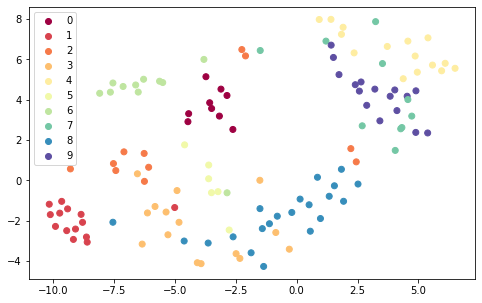

In [ ]:
plt.figure(figsize=(8,5))
scatter  = plt.scatter(z_train_tsne[:,0], z_train_tsne[:,1], c=train_labels, cmap='Spectral')
plt.legend(handles=scatter.legend_elements()[0], labels=list(set(train_labels)))
plt.show()

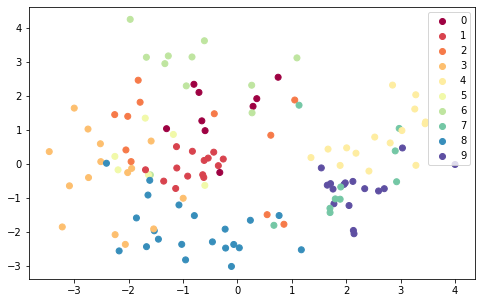

In [ ]:
plt.figure(figsize=(8,5))
scatter  = plt.scatter(z_train_pca[:,0], z_train_pca[:,1], c=train_labels, cmap='Spectral')
plt.legend(handles=scatter.legend_elements()[0], labels=list(set(train_labels)))
plt.show()

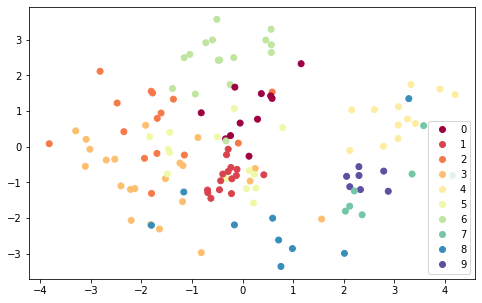

In [ ]:
plt.figure(figsize=(8,5))
scatter  = plt.scatter(z_test_pca[:,0], z_test_pca[:,1], c=test_labels, cmap='Spectral')
plt.legend(handles=scatter.legend_elements()[0], labels=list(set(test_labels)))
plt.show()

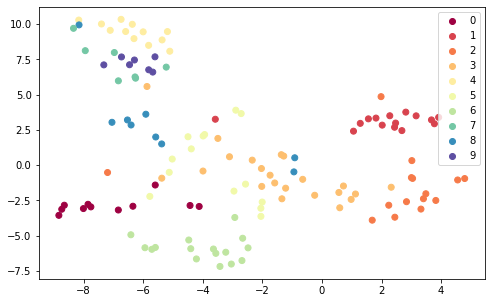

In [ ]:
plt.figure(figsize=(8,5))
scatter  = plt.scatter(z_test_tsne[:,0], z_test_tsne[:,1], c=test_labels, cmap='Spectral')
plt.legend(handles=scatter.legend_elements()[0], labels=list(set(test_labels)))
plt.show()

(128, 8)

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from matplotlib.colors import Colormap
import seaborn as sns

In [ ]:
z_l[0]

array([-2.6060193 ,  0.24894208], dtype=float32)

In [ ]:
print('[%s]' % ', '.join(map(str, np.mean(disc_loss, axis=0))))

[0.5, 0.5]


In [ ]:
class Encoder(nn.Module):

    def __init__(self, args):
        super(Encoder, self).__init__()
        
        self.n_z = args.n_z
        self.channels = args.n_channel
        self.dim_input = args.img_size ** 2

        self.main = nn.Sequential(
            nn.Conv1d(self.channels, self.channels * 512, kernel_size=5, stride=3),
            nn.LeakyReLU(0.1, True),
            nn.Conv1d(self.channels * 512, self.channels * 256, kernel_size=4, stride=3),
            nn.LeakyReLU(0.1, True),
            nn.Conv1d(self.channels * 256, self.channels * 128, kernel_size=4, stride=3),
            nn.LeakyReLU(0.1, True),
            nn.Conv1d(self.channels * 128, self.channels, kernel_size=4, stride=2),
            nn.LeakyReLU(0.1, True),
            nn.Linear(13, self.n_z)
        )
    
    def forward(self, x):
        x = self.main(x)
        return x

In [ ]:
class Decoder(nn.Module):

    def __init__(self, args):
        super(Decoder, self).__init__()

        self.n_z = args.n_z
        self.channels = args.n_channel
        self.dim_output = args.img_size ** 2

        self.main = nn.Sequential(
            nn.Linear(self.n_z, 196),
            nn.LeakyReLU(0.1, True),
            nn.ConvTranspose1d(self.channels, self.channels * 512, kernel_size=6, stride=2, padding=2),
            nn.LeakyReLU(0.1, True),
            nn.ConvTranspose1d(self.channels*512, self.channels * 256, kernel_size=6, stride=1, padding=2),
            nn.LeakyReLU(0.1, True),
            nn.ConvTranspose1d(self.channels * 256, self.channels * 1, kernel_size=4, stride=2, padding=2),
            # nn.LeakyReLU(0.1, True),
            # nn.ConvTranspose1d(self.channels * 256, self.channels * 128, kernel_size=4, stride=3),
            # nn.LeakyReLU(0.1, True),
            # nn.ConvTranspose1d(self.channels * 128, self.channels * 1, kernel_size=4, stride=3),
            # nn.LeakyReLU(0.1, True),
            # nn.ConvTranspose1d(self.channels * 32, self.channels, kernel_size=4, stride=2),
            # nn.Linear(715, self.dim_output),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = self.main(x)
        return x